# 01 Import libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import pandas as pd

In [4]:
import importlib

## Import our own modules

In [5]:
!rm -r Learning-the-Optimal-Solution-Path
!git clone https://github.com/Cumberkid/Learning-the-Optimal-Solution-Path.git

rm: cannot remove 'Learning-the-Optimal-Solution-Path': No such file or directory
Cloning into 'Learning-the-Optimal-Solution-Path'...
remote: Enumerating objects: 1744, done.
remote: Counting objects: 100% (714/714), done.
remote: Compressing objects: 100% (355/355), done.
remote: Total 1744 (delta 542), reused 479 (delta 359), pack-reused 1030 (from 1)
Receiving objects: 100% (1744/1744), 13.25 MiB | 7.50 MiB/s, done.
Resolving deltas: 100% (1179/1179), done.


(Using Colab)

In [6]:
import sys

In [7]:
# Add the parent directory to sys.path
sys.path.append('/content/Learning-the-Optimal-Solution-Path')

In [8]:
import lib
importlib.reload(lib)

<module 'lib' from '/content/Learning-the-Optimal-Solution-Path/lib/__init__.py'>

In [9]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.lsp.basis_generator import dampen_laguerre
from lib.lsp.basis_tf_module import Basis_TF_SGD
from lib.lsp.reg_solver_lsp import train_lsp, test_lsp
from lib.lsp.loss_fn_lsp import reg_exp_weighted_logit

# 02 Instantiate dataset

In [10]:
# file path for Colab. May need to change this
X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')

In [11]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [12]:
input_dim = X.shape[1]

In [13]:
X_tune = X[:200, :]
y_tune = y[:200]

In [14]:
train_X = torch.tensor(X_tune, dtype=torch.float32)
train_y = torch.tensor(y_tune, dtype=torch.float32)

In [15]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=20, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

# 03 Define Functions

In [16]:
loss_fn = reg_exp_weighted_logit

In [17]:
def gen_loss_gd(lam, lr):
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    weight = model.linear.weight.clone().detach()
    itr = 0
    for t in range(epochs):
        grad, weight, itr = train_lsp(itr, weight, GD_data_loader, model, loss_fn,
                                      optimizer, weighted_avg=True, step_size=None,
                                      const=None, distribution='exponential', device='cpu')

    loss = test_lsp(test_data_loader, model, loss_fn, lam, device)
    return loss

In [18]:
def gen_loss_sgd(lam, step_size, const):
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    weight = model.linear.weight.clone().detach()
    itr = 0
    for t in range(epochs):
        grad, weight, itr = train_lsp(itr, weight, SGD_data_loader, model, loss_fn,
                                      optimizer, weighted_avg=True, step_size=step_size,
                                      const=beta, distribution='exponential', device='cpu')
    loss = test_lsp(test_data_loader, model, loss_fn, lam, device)
    return loss

# 04 Tuning the learning rate for our model

In [19]:
lr_list = 0.5 ** np.arange(-3, 11)
beta_list = 0.5 ** np.arange(-3, 11)

In [20]:
lam = 7

Laguerre polynomials

In [21]:
phi_lam = dampen_laguerre

In [22]:
epochs = 100

## Basis dimension = 5

In [23]:
basis_dim = 5

### Exact Gradient:

pick lr = 0.0625

In [24]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: nan
learning rate: 4.0	 loss: nan
learning rate: 2.0	 loss: 2.0501054006860186e+17
learning rate: 1.0	 loss: 19.664724349975586
learning rate: 0.5	 loss: 3.68190860748291
learning rate: 0.25	 loss: 0.1956593543291092
learning rate: 0.125	 loss: 0.16215011477470398
learning rate: 0.0625	 loss: 0.15909706056118011
learning rate: 0.03125	 loss: 0.15994687378406525
learning rate: 0.015625	 loss: 0.1614844650030136
learning rate: 0.0078125	 loss: 0.16532552242279053
learning rate: 0.00390625	 loss: 0.17424848675727844
learning rate: 0.001953125	 loss: 0.17594993114471436
learning rate: 0.0009765625	 loss: 0.1855485588312149


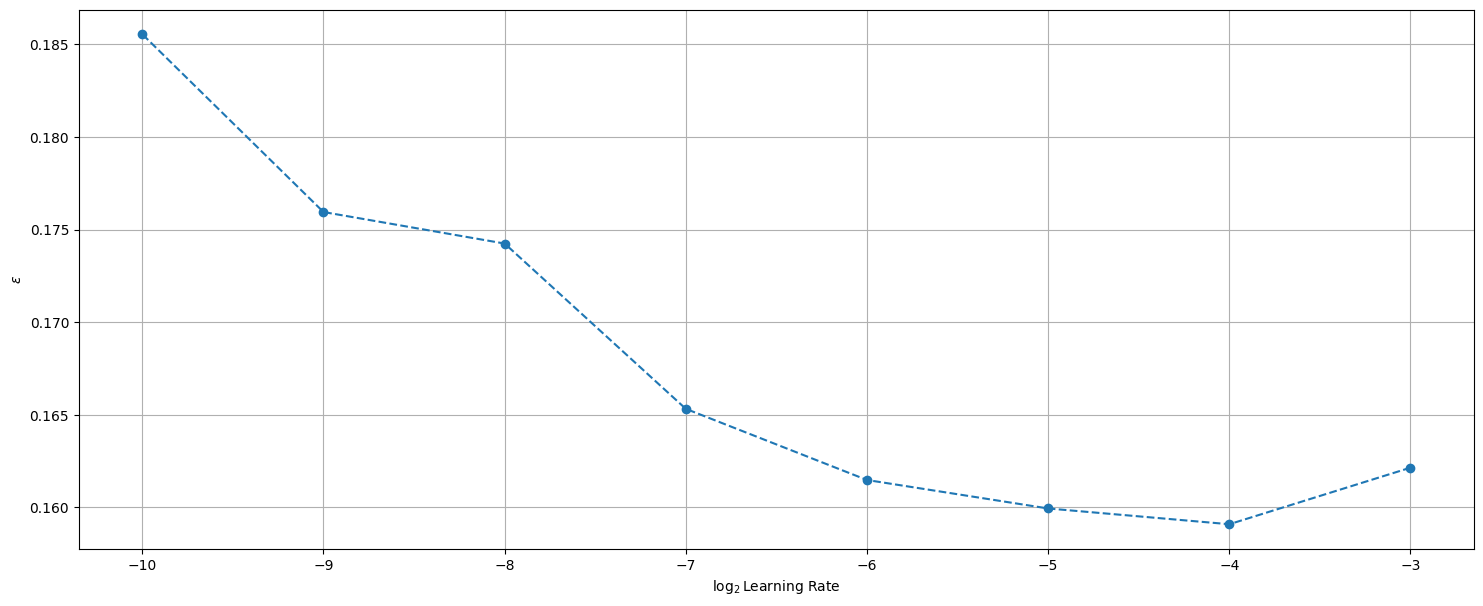

In [25]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[6:]), losses[6:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

### Noisy gradient:

In [26]:
# beta/sqrt(t)
def step_size(t, beta):
    return beta/np.sqrt(t+1)

pick $\beta = 0.125$

In [27]:
losses = []
losses_avg = []
for beta in beta_list:
    loss = gen_loss_sgd(lam, step_size, beta)

    print(f"learning rate: {beta}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: 0.1633756011724472
learning rate: 4.0	 loss: 0.7012208104133606
learning rate: 2.0	 loss: 0.43111640214920044
learning rate: 1.0	 loss: 0.22343647480010986
learning rate: 0.5	 loss: 0.15922679007053375
learning rate: 0.25	 loss: 0.16051678359508514
learning rate: 0.125	 loss: 0.15960291028022766
learning rate: 0.0625	 loss: 0.15963605046272278
learning rate: 0.03125	 loss: 0.1599484235048294
learning rate: 0.015625	 loss: 0.1647396981716156
learning rate: 0.0078125	 loss: 0.16914944350719452
learning rate: 0.00390625	 loss: 0.17785340547561646
learning rate: 0.001953125	 loss: 0.18294502794742584
learning rate: 0.0009765625	 loss: 0.19477592408657074


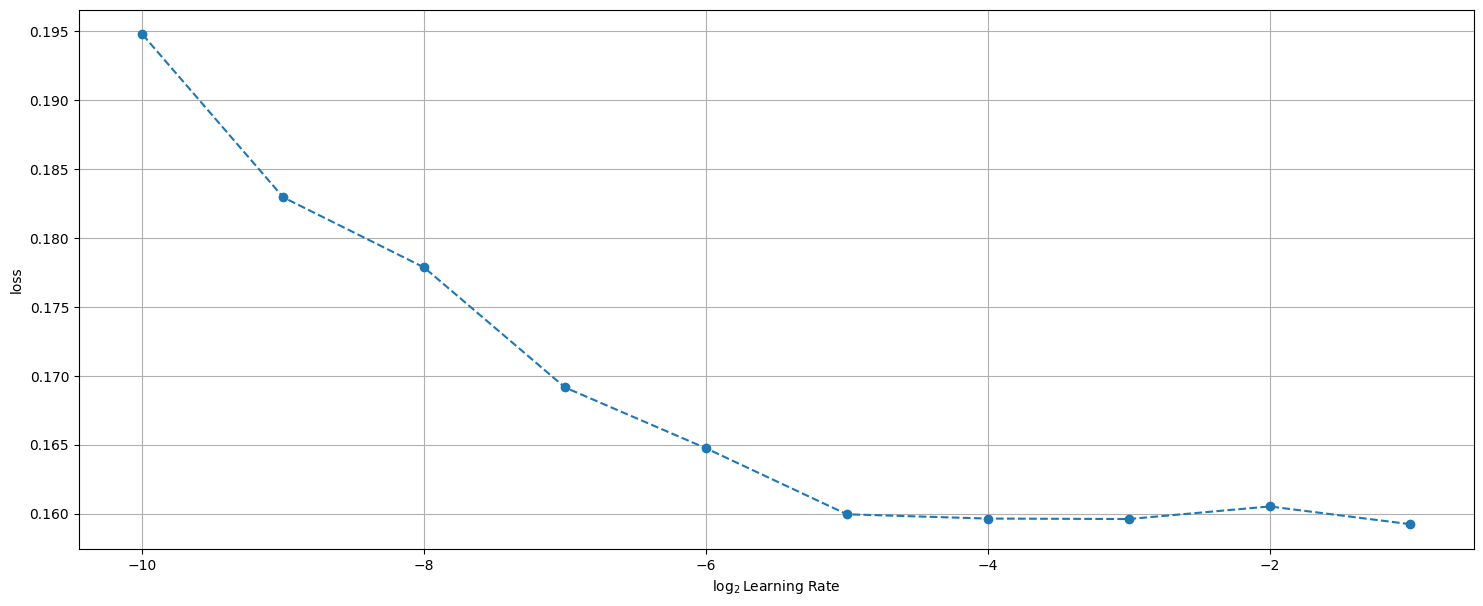

In [28]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(beta_list[4:]), losses[4:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("loss")
plt.grid(True)

## Basis dimension = 7

In [29]:
basis_dim = 7

### Exact Gradient:

pick lr = 0.0625

In [30]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: nan
learning rate: 4.0	 loss: nan
learning rate: 2.0	 loss: 1.4237033876897535e+21
learning rate: 1.0	 loss: 305991.5625
learning rate: 0.5	 loss: 3.56817889213562
learning rate: 0.25	 loss: 0.1785079538822174
learning rate: 0.125	 loss: 0.16011209785938263
learning rate: 0.0625	 loss: 0.1588202863931656
learning rate: 0.03125	 loss: 0.15972624719142914
learning rate: 0.015625	 loss: 0.16214443743228912
learning rate: 0.0078125	 loss: 0.16717755794525146
learning rate: 0.00390625	 loss: 0.1707516610622406
learning rate: 0.001953125	 loss: 0.178631991147995
learning rate: 0.0009765625	 loss: 0.1856299638748169


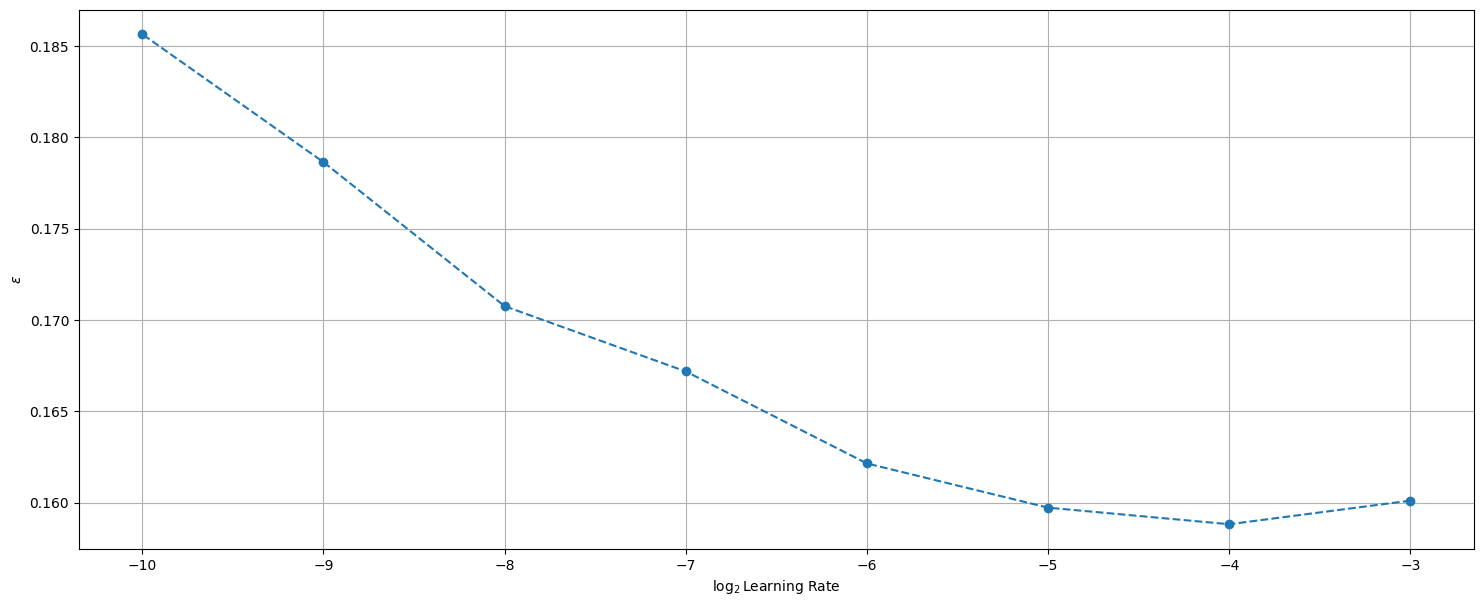

In [31]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[6:]), losses[6:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

### Noisy gradient:

In [32]:
# beta/sqrt(t)
def step_size(t, beta):
    return beta/np.sqrt(t+1)

pick $\beta = 0.0625$

In [33]:
losses = []
losses_avg = []
for beta in beta_list:
    loss = gen_loss_sgd(lam, step_size, beta)

    print(f"learning rate: {beta}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: 3.484330415725708
learning rate: 4.0	 loss: 0.21582652628421783
learning rate: 2.0	 loss: 0.3573569357395172
learning rate: 1.0	 loss: 0.3639751076698303
learning rate: 0.5	 loss: 0.21545115113258362
learning rate: 0.25	 loss: 0.16399715840816498
learning rate: 0.125	 loss: 0.16419552266597748
learning rate: 0.0625	 loss: 0.16702893376350403
learning rate: 0.03125	 loss: 0.15944142639636993
learning rate: 0.015625	 loss: 0.16449372470378876
learning rate: 0.0078125	 loss: 0.18133381009101868
learning rate: 0.00390625	 loss: 0.1737174540758133
learning rate: 0.001953125	 loss: 0.18244948983192444
learning rate: 0.0009765625	 loss: 0.19751599431037903


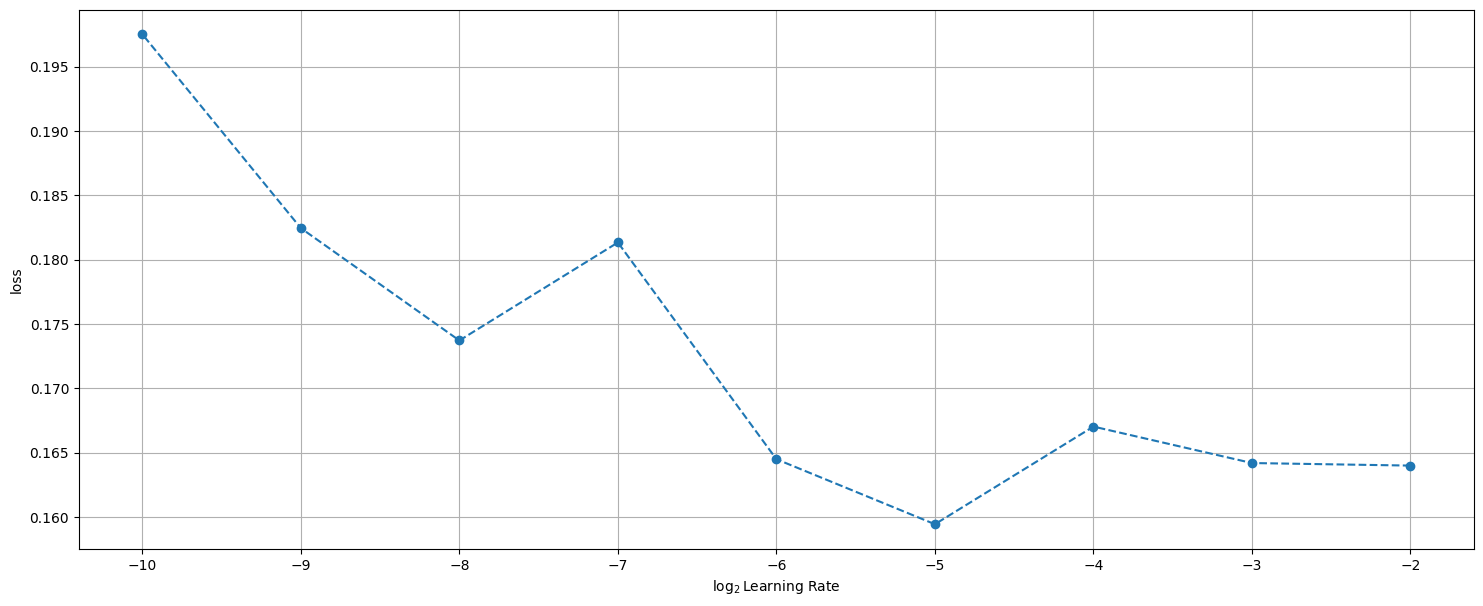

In [35]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(beta_list[5:]), losses[5:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("loss")
plt.grid(True)

## Basis dimension = 9

In [36]:
basis_dim = 9

### Exact Gradient:

pick lr = 0.03125

In [37]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: nan
learning rate: 4.0	 loss: nan
learning rate: 2.0	 loss: 3.61725362623956e+27
learning rate: 1.0	 loss: 192063.890625
learning rate: 0.5	 loss: 0.6198861002922058
learning rate: 0.25	 loss: 0.3322352468967438
learning rate: 0.125	 loss: 0.15981654822826385
learning rate: 0.0625	 loss: 0.1594190150499344
learning rate: 0.03125	 loss: 0.15911366045475006
learning rate: 0.015625	 loss: 0.16112682223320007
learning rate: 0.0078125	 loss: 0.16602033376693726
learning rate: 0.00390625	 loss: 0.1715543419122696
learning rate: 0.001953125	 loss: 0.17940126359462738
learning rate: 0.0009765625	 loss: 0.1913294494152069


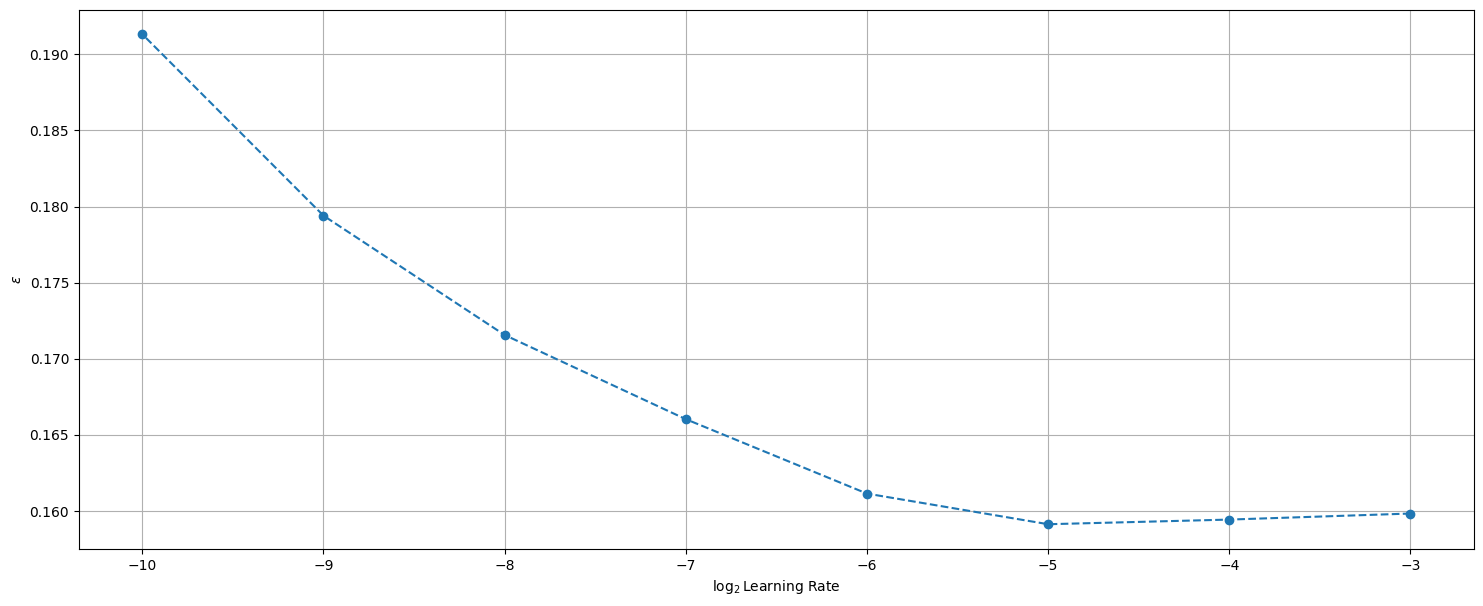

In [39]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[6:]), losses[6:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

### Noisy gradient:

In [40]:
# beta/sqrt(t)
def step_size(t, beta):
    return beta/np.sqrt(t+1)

pick $\beta = 0.0625$

In [41]:
losses = []
losses_avg = []
for beta in beta_list:
    loss = gen_loss_sgd(lam, step_size, beta)

    print(f"learning rate: {beta}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: 5698633216.0
learning rate: 4.0	 loss: 0.6832017302513123
learning rate: 2.0	 loss: 0.9504539966583252
learning rate: 1.0	 loss: 0.34747132658958435
learning rate: 0.5	 loss: 0.16244404017925262
learning rate: 0.25	 loss: 0.16325901448726654
learning rate: 0.125	 loss: 0.1634669303894043
learning rate: 0.0625	 loss: 0.15966275334358215
learning rate: 0.03125	 loss: 0.16334675252437592
learning rate: 0.015625	 loss: 0.16294820606708527
learning rate: 0.0078125	 loss: 0.1710018515586853
learning rate: 0.00390625	 loss: 0.17485561966896057
learning rate: 0.001953125	 loss: 0.18680505454540253
learning rate: 0.0009765625	 loss: 0.1937267780303955


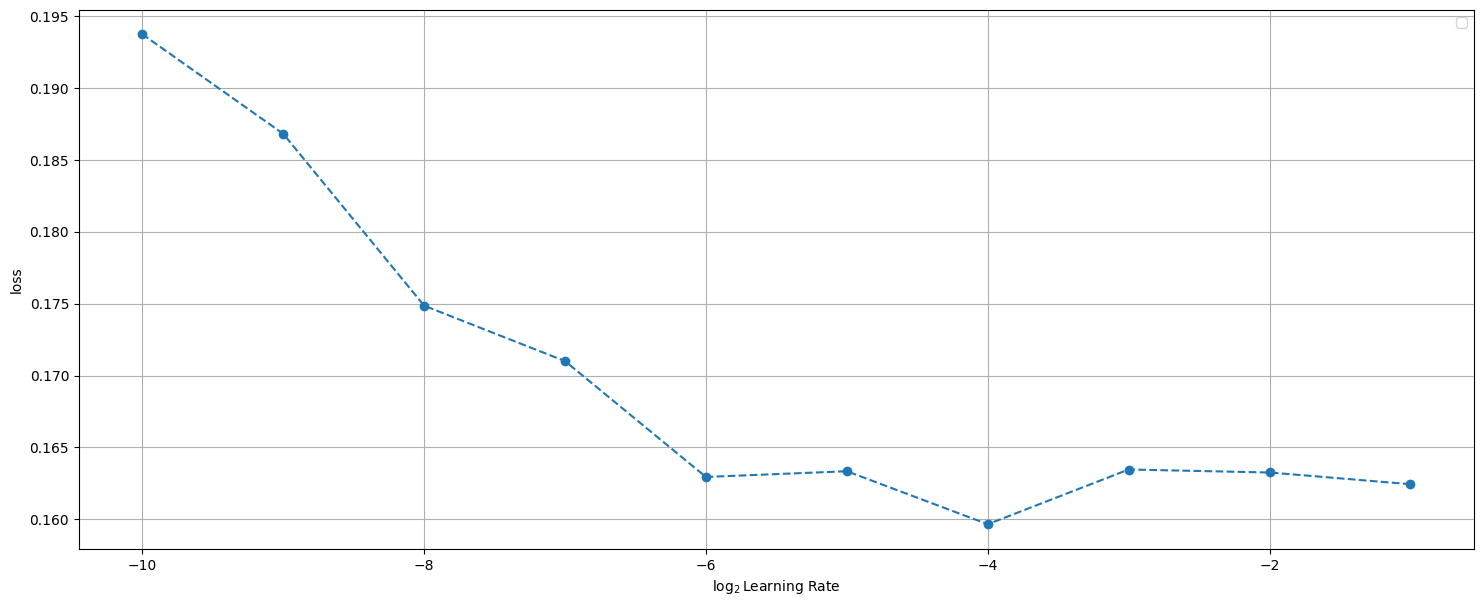

In [42]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(beta_list[4:]), losses[4:], '--o')
plt.legend()
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("loss")
plt.grid(True)